In [32]:
import geopandas as gpd
from shapely import geometry
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import (
    Voronoi,
    voronoi_plot_2d,
    Delaunay,
    delaunay_plot_2d,
    cKDTree
)
import numpy as np
import math, time
import interpolators

plt.rcParams["figure.figsize"] = 30, 20
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

def getPolygonsFromContour(contour):
    polygons = []
    for col in contour.collections:
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths():
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for idx, poly_coords in enumerate(contour_path.to_polygons()):
                x = poly_coords[:, 0]
                y = poly_coords[:, 1]

                new_shape = geometry.Polygon(
                    [(point[0], point[1]) for point in zip(x, y)]
                )
                if idx == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    poly = poly.difference(new_shape)
                    # Can also be left out if you want to include all rings

            polygons.append(poly)
    return polygons

def plotPolygons(polygons):
    fig, ax = plt.subplots()
    for p in polygons:
        plt.plot(*zip(*p.exterior.coords))

def getCmapColors(cmapName, n, rgb=True):
    cmap = cm.get_cmap(cmapName, n)    # PiYG

    colors = []
    for i in range(cmap.N):
        rgbValues = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        if rgb:
            colors.append(",".join(list(map(str,rgbValues))))
        else:
            colors.append(mpl.colors.rgb2hex(rgbValues))
    return colors

external_crs = "EPSG:4326"
internal_crs = "EPSG:3068"
berlinDistricts = gpd.read_file("../shared/berlinDistricts.geojson")
measurements = gpd.read_file("raw-test/data_2020-02-12T14-00-00.geojson")

berlinDistricts = berlinDistricts.to_crs(internal_crs)
measurements = measurements.to_crs(internal_crs)

x = np.array(measurements.geometry.x)
y = np.array(measurements.geometry.y)
values = np.array(measurements.value)
points = np.column_stack((x, y))

xmin, ymin, xmax, ymax = measurements.total_bounds
size = 500  # grid cell size in meters
xnew = np.linspace(xmin, xmax, int((xmax - xmin) / size))
ynew = np.linspace(ymin, ymax, int((ymax - ymin) / size))

In [ ]:
# Plot Berlin Boundaries with Measurements

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Measurements")
berlinPlot = berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
measurements.plot(ax=ax, column="value", legend=True)

In [ ]:
# Plot Berlin boundaries with interpolation grid

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Interpolation Grid")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
xx, yy = np.meshgrid(xnew,ynew)
ax.scatter(xx, yy, s=1)

In [ ]:
# Plot Berlin with Voronoi diagram

voronoi = Voronoi(points)

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Voronoi Diagram")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
voronoi_plot_2d(voronoi, ax=ax, show_vertices=False, show_points=True, line_colors='orange')
fig.savefig("voronoi.png")

In [ ]:
# Plot Berlin with Delauny diagram

delauny = Delaunay(points)

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Delauny Diagram")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
delaunay_plot_2d(delauny, ax=ax)

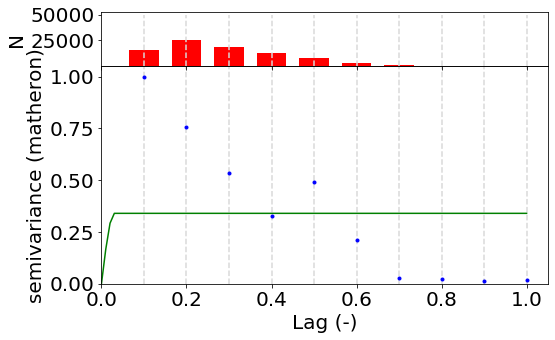

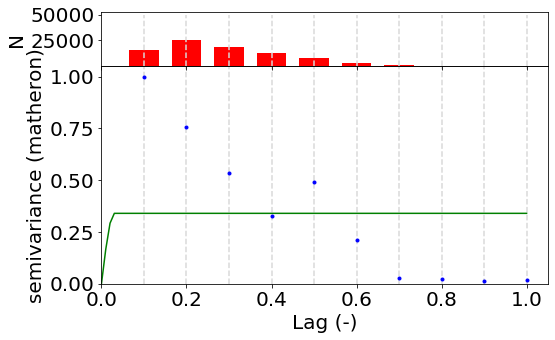

In [44]:
from skgstat import Variogram

V = Variogram(points, values)
V.plot()
# V.distance_difference_plot()
# print(V.distance)

(13482, 2)
9.81217089836462
9.81217089836462


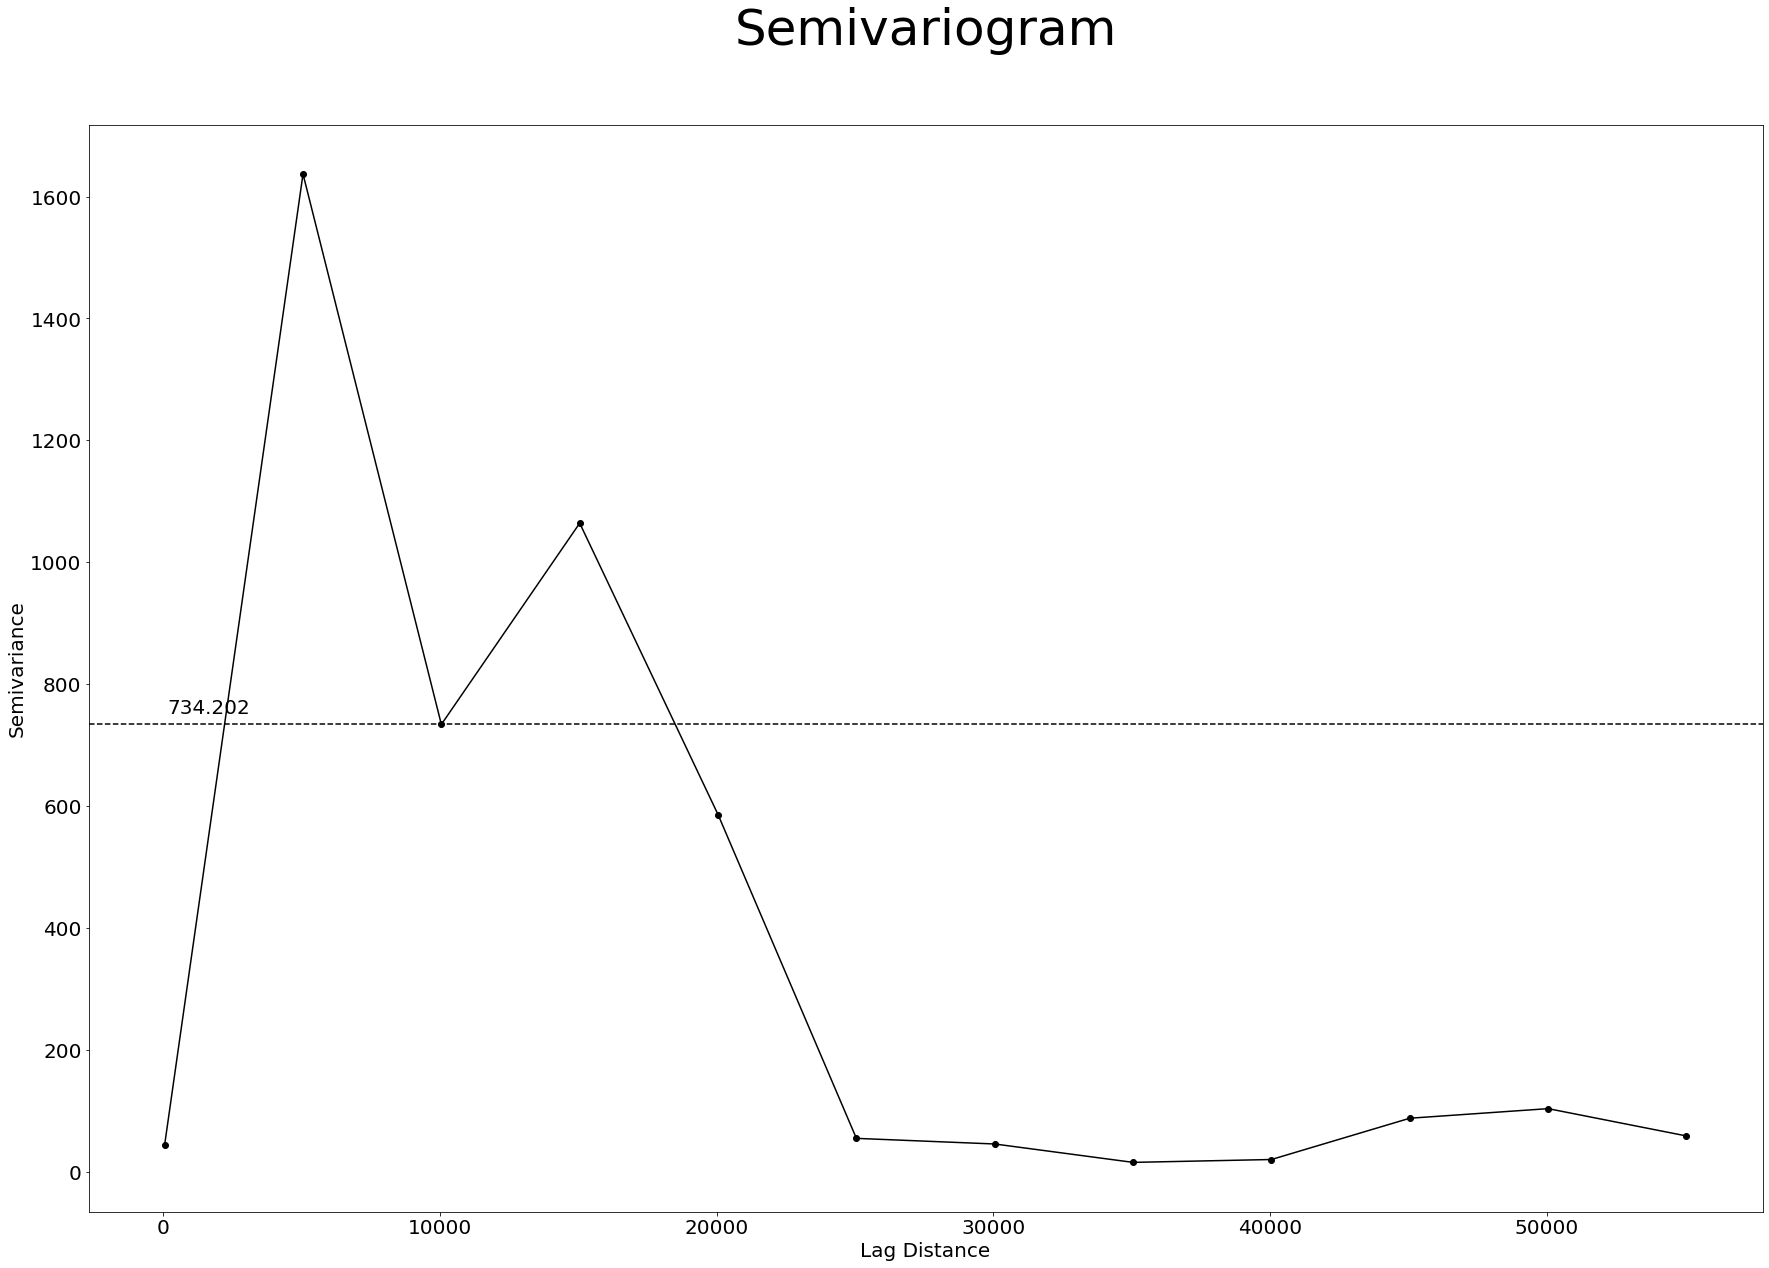

LinAlgError: Singular matrix

In [59]:
import collections, random
from scipy import interpolate
from scipy.spatial.distance import cdist

from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

def ordinary_kriging(x, y, points, value): 
    
    ok_interpolator = OrdinaryKriging(points[:, 0], points[:, 1], values, variogram_model='linear',
                     verbose=True, enable_plotting=True)
    xx, yy = np.meshgrid(x, y)
    ok_interpolator.display_variogram_model()
    # result = ok_interpolator.execute('grid', x, y)
    print(result[0])
    print(np.min(result[0]))
    print(np.max(result[0]))
    return result[0]

def spline(x, y, points, values):
    xx, yy = np.meshgrid(x, y)
    point_matrix = np.dstack((xx, yy))
    tck = interpolate.bisplrep(points[:,0], points[:,1], values)
    grid_values = interpolate.bisplev(xnew, ynew, tck).T
    print(grid_values.shape)
    return grid_values

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from geostatsmodels import utilities, kriging, variograms, model, geoplot
from geostatsmodels.kriging import krige
from scipy.stats import norm
def kriging(x, y, points, values):
    gpr = GaussianProcessRegressor(normalize_y=True)
    gpr.fit(points, values)

    xx, yy = np.meshgrid(x, y)
    new_points = np.column_stack([xx.flatten(), yy.flatten()])
    result = gpr.predict(new_points)
    print(new_points.shape)
    print(np.min(result))
    print(np.max(result))
    # return result.reshape(y.shape[0], x.shape[0])


    x_point_dup = [
        item for item, count in collections.Counter(points[:, 0]).items() if count > 1
    ]
    y_point_dup = [
        item for item, count in collections.Counter(points[:, 1]).items() if count > 1
    ]
    fixed_x = list(
        map(
            lambda x: x + random.uniform(-0.00001, 0.00001) if x in x_point_dup else x,
            points[:, 0],
        )
    )
    fixed_y = list(
        map(
            lambda y: y + random.uniform(-0.00001, 0.00001) if y in y_point_dup else y,
            points[:, 1],
        )
    )

    fixed_points = np.column_stack((fixed_x, fixed_y))


    nugget = 50
    lags = np.arange(nugget, 60000, 5000)
    sill = np.var(values)
    P = np.array(list(zip(fixed_points[:,0], fixed_points[:, 1], values)))
    geoplot.semivariogram(P, lags, nugget)
    svm = model.semivariance(model.spherical, (4000, sill))
    # geoplot.semivariogram(P, lags, nugget, model=svm)
    covfct = model.covariance(model.spherical, (4000, sill))
    # kriging.simple(P, covfct, pt, N=6)
    est, kstd = krige(P, covfct, new_points, 'simple', N=6)


start = time.time()

# interpolated_values = interpolators.nearest_neighbor(xnew, ynew, points, values)
# interpolated_values = rbf(xnew, ynew, points, values)
interpolated_values = kriging(xnew, ynew, points, values)
# interpolated_values = ordinary_kriging(xnew, ynew, points, values)
# interpolated_values = interpolators.linear_barycentric(xnew, ynew, points, values)
# interpolated_values = interpolators.natural_neighbor(xnew, ynew, points, values)
# interpolated_values = interpolators.discrete_natural_neighbor(xnew, ynew, points, values)
# interpolated_values = interpolators.inverse_distance_weighting(xnew, ynew, points, values, k=10)

# interpolated_values = np.array([list(map(getMeasurementValue, row)) for row in interpolated_values])

# print(interpolated_values.shape)

end = time.time()
print(end - start)